### Part 1 - Summary statistics and plots

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("company_portfolio.csv")
df_annual = df.groupby(['Location number','State'],as_index=False)[['Gross revenue','Fixed cost','Variable cost','Rental cost','Number of products']].sum()
df_annual['Profit margin'] = (df_annual['Gross revenue']-(df_annual['Fixed cost']+df_annual['Rental cost']+df_annual['Variable cost']))/df_annual['Gross revenue']

# mean and median annual profit margin
print('Mean: ' + str(np.mean(df_annual['Profit margin'])))
print('Median: ' + str(np.median(df_annual['Profit margin'])))
ax = df_annual.hist(column='Profit margin', bins = 20)
plt.show()

Mean: 0.2486322925670752
Median: 0.26184928404393776


<Figure size 640x480 with 1 Axes>

The profit margin across locations is left-skewed, indicating that profit margin is not normally distributed. The median annual profit margin is higher than the mean annual profit margin.

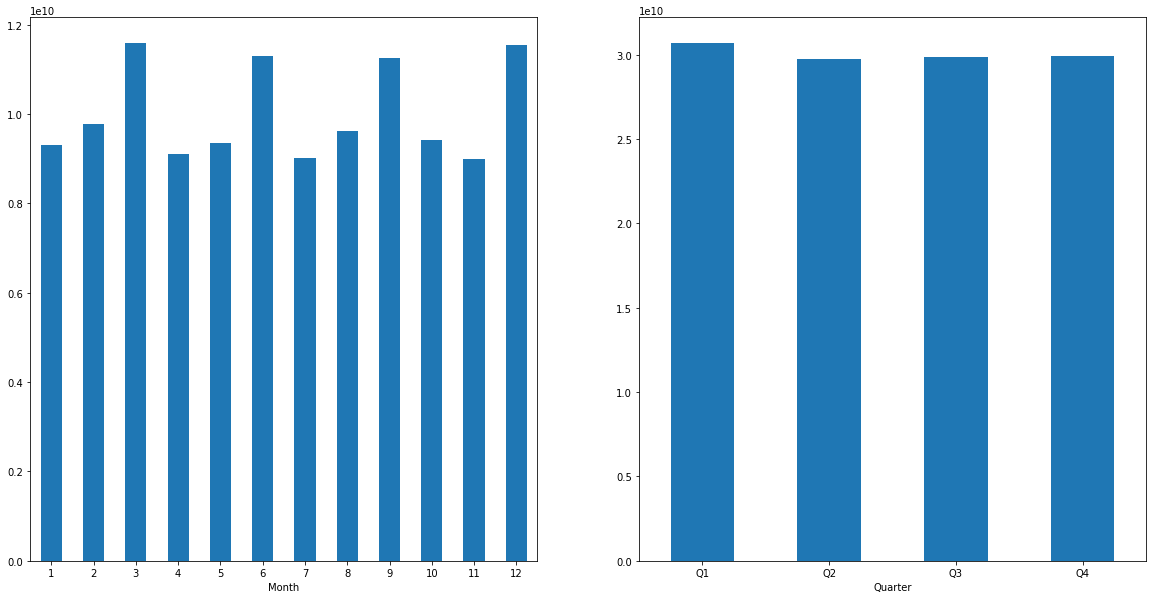

In [3]:
#monthly and quarterly aggregate revenue across all stores
df_month = df.groupby('Month').sum()['Gross revenue']

def label_quarter (row):
    if row['Month'] in [1,2,3]:
        return 'Q1'
    if row['Month'] in [4,5,6]:
        return 'Q2'
    if row['Month'] in [7,8,9]:
        return 'Q3'
    return 'Q4'
df['Quarter'] = df.apply (lambda row: label_quarter(row), axis=1)
df_quarter = df.groupby('Quarter').sum()['Gross revenue']

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1 = df_month.plot.bar(x='Month', y='Gross revenue', rot=0)
ax2 = fig.add_subplot(122)
ax2 = df_quarter.plot.bar(x='Quarter', y='Gross revenue', rot=0)
plt.show()

The monthly aggregate revenue across all stores increases in the last month of each quarter. Potential factors that may contribute to this increase in monthly revenue include seasonal holidays and end-of-quarter sales crunches. The quarterly aggregate revenue across all stores is fairly constant throughout all four quarters.

### Part 2 - Cleaning the data

To impute the appropriate rental cost for each owned location, we use the number of products as a proxy for the size of the store. Computing the average rental cost per product in each state, we are then able to impute the rental cost for each owned location and adjust the annual profit margin for this added cost.

In [4]:
leased = df[df['Owned']==False]

rental_tot = leased.groupby('State').sum()['Rental cost']
product_tot = leased.groupby('State').sum()['Number of products']
rental_rate = rental_tot/product_tot
print(rental_rate)

def impute_rent (row):
    if row['Rental cost'] == 0:
        return rental_rate[row['State']]*row['Number of products']
    return row['Rental cost']

df['Rental cost imputed'] = df.apply (lambda row: impute_rent(row), axis=1)
df_annual = df.groupby(['Location number','State'],as_index=False)[['Gross revenue','Fixed cost','Variable cost','Rental cost imputed','Number of products']].sum()
df_annual['Profit margin'] = (df_annual['Gross revenue']-(df_annual['Fixed cost']+df_annual['Rental cost imputed']+df_annual['Variable cost']))/df_annual['Gross revenue']

State
CA    36.204044
CO    35.424065
GA    33.967610
IL    35.398572
NJ    37.005606
TX    39.761226
WA    37.144854
dtype: float64


### Part 3 - Quantify drivers of success
To determine factors that contribute to higher profit margins across all locations, we consider metrics such as the ratio of fixed cost and the ratio of variable cost to gross revenue. In the graphs below, the red line represents the cutoff for underperforming stores and the green line represents the cutoff for the overperforming store. These thresholds are defined by a z-score of 2. To analyze the drivers for these underperformers and overperformers, we plot the annual profit margin against the fixed cost and variable cost to revenue ratios.

In [5]:
from scipy.stats import skew 
print('Skewness: '+ str(skew(df_annual['Profit margin']))) #check normality
pm_mean = np.mean(df_annual['Profit margin'])
pm_std = np.std(df_annual['Profit margin'])
print('Mean: ' + str(pm_mean))
print('Std: ' + str(pm_std))

# compute ratios for analysis
df_annual['Cost ratio'] = (df_annual['Fixed cost']+df_annual['Rental cost imputed'])/df_annual['Variable cost']
df_annual['Fixed cost to revenue ratio'] = (df_annual['Fixed cost']+df_annual['Rental cost imputed'])/df_annual['Gross revenue']
df_annual['Variable cost to revenue ratio'] = df_annual['Variable cost']/df_annual['Gross revenue']

Skewness: -0.7528950794107157
Mean: 0.24807131306001073
Std: 0.06210137255371707


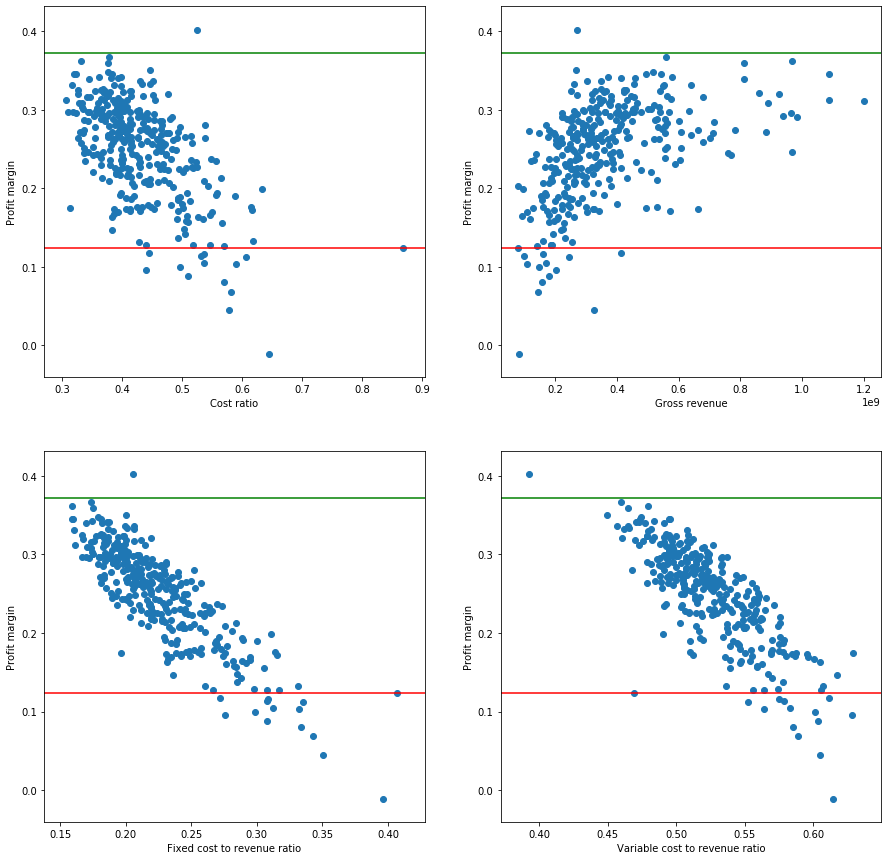

In [6]:
# use z-score to define cutoff of underperformers and overperformers
df_under = df_annual[df_annual['Profit margin'] < pm_mean - 2*pm_std]
df_outer = df_annual[df_annual['Profit margin'] > pm_mean + 2*pm_std]

# fixed cost to variable cost ratio
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
ax1.scatter(df_annual['Cost ratio'],df_annual['Profit margin'])
ax1.set_xlabel('Cost ratio')
ax1.set_ylabel('Profit margin')
ax1.axhline(y=pm_mean - 2*pm_std, color='r', linestyle='-')
ax1.axhline(y=pm_mean + 2*pm_std, color='g', linestyle='-')

# gross revenue
ax2 = fig.add_subplot(222)
ax2.scatter(df_annual['Gross revenue'],df_annual['Profit margin'])
ax2.set_xlabel('Gross revenue')
ax2.set_ylabel('Profit margin')
ax2.axhline(y=pm_mean - 2*pm_std, color='r', linestyle='-')
ax2.axhline(y=pm_mean + 2*pm_std, color='g', linestyle='-')

# fixed cost to revenue ratio
ax3 = fig.add_subplot(223)
ax3.scatter(df_annual['Fixed cost to revenue ratio'],df_annual['Profit margin'])
ax3.set_xlabel('Fixed cost to revenue ratio')
ax3.set_ylabel('Profit margin')
ax3.axhline(y=pm_mean - 2*pm_std, color='r', linestyle='-')
ax3.axhline(y=pm_mean + 2*pm_std, color='g', linestyle='-')

# variable cost to revenue ratio
ax4 = fig.add_subplot(224)
ax4.scatter(df_annual['Variable cost to revenue ratio'],df_annual['Profit margin'])
ax4.set_xlabel('Variable cost to revenue ratio')
ax4.set_ylabel('Profit margin')
ax4.axhline(y=pm_mean - 2*pm_std, color='r', linestyle='-')
ax4.axhline(y=pm_mean + 2*pm_std, color='g', linestyle='-')
plt.show()

#### Gross revenue
The store with the highest profit margin has a relatively low gross revenue, suggesting that this store has low fixed and/or variable costs.

The scatterplot for gross revenue and profit margin shows that a significantly large number of stores with high gross revenue have very high profit margins. These stores should act as a model of outperformance for other stores. In addition, underperforming stores tend to have lower gross revenues in comparison to other stores. However, we also observe several stores with similar levels of revenue, but higher profit margins; this implies these underperforming stores are likely inefficient.

#### Fixed costs
The graph of profit margin against fixed cost (including imputed rental cost) to revenue ratios suggests that underperforming stores are associated with higher fixed costs relative to gross revenue. Since stores with higher operating costs are generally less efficient, the profit margin for these stores is likely to be lower in comparison to the company's other stores. Contrarily, high-performing stores tend to have lower fixed cost to revenue ratios, which allows them to efficiently generate revenue.

#### Variable costs
The relationship between variable costs and profit margin is similar to that of fixed costs. However, we observe that the highest performing store has the lowest variable cost to revenue ratio. This suggests that the store's ability to scale its operation is significant as a factor leading to historical outperformance. Conversely, stores with high variable cost to revenue ratios are associated with underperforming profit margins, suggesting that these stores are much less effective in producing output.

#### Cost ratio
Stores with lower fixed cost (including imputed rental cost) to variable cost ratios are associated with higher profit margins. This corroborates the earlier discussion of efficiency as a factor contributing to high performing stores. Stores that spend less on operating costs are able to allocate more of their resources toward producing products and generating revenue.

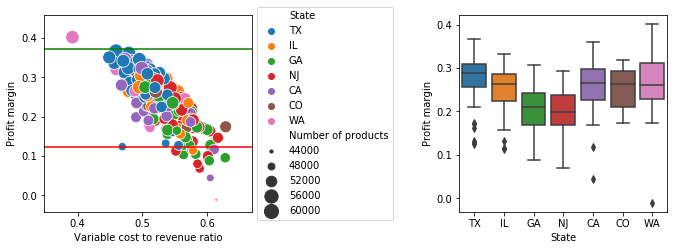

In [7]:
import seaborn as sns
# state and number of products
fig, ax = plt.subplots(1,2,figsize=(10,4))
g = sns.scatterplot(x='Variable cost to revenue ratio', y='Profit margin',
                    data=df_annual,
                    hue='State', size = 'Number of products',
                    sizes=(10, 200), ax = ax[0])
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
g.axhline(y=pm_mean - 2*pm_std, color='r', linestyle='-')
g.axhline(y=pm_mean + 2*pm_std, color='g', linestyle='-')

sns.boxplot(x='State', y='Profit margin', data=df_annual, ax = ax[1])
fig.tight_layout(pad=3.0)

### Location
While there is considerable variation between stores within a given state, several of the underperforming stores are located in Georgia and New Jersey. Compared to the average rental rates across all states (printed above), the rental costs in Georgia and New Jersey are not significantly higher. This suggests that other state-related factors, such as customer base or statewide operating practices, may drive underperformance. Interestingly, the mean profit margins of stores in Georgia and New Jersey are lower than that of stores in other states (see boxplot).

### Number of products
The number of products does not seem to be a significant factor in determining the profit margin of a store. Although underperforming stores tend to have fewer products, stores with high profit margins do not necessarily have higher numbers of products. Rather, the ability to scale efficiently is a driver of profit margin.

## Underperforming stores
To better understand the factors that contribute to underperforming stores, we analyze the revenues and costs of these stores compared to other stores in their states.

In [46]:
df_under[['Location number','State','Profit margin','Cost ratio']].sort_values(by=['Profit margin'])


,Location number,State,Profit margin,Cost ratio
156,157,WA,-0.010842,0.644578
312,313,CA,0.044470,0.578486
125,126,NJ,0.068526,0.581736
287,288,NJ,0.080338,0.570410
110,111,GA,0.088220,0.510042
207,208,GA,0.095753,0.438831
71,72,NJ,0.099958,0.496296
12,13,GA,0.103652,0.589066
111,112,GA,0.104796,0.535947
40,41,NJ,0.112716,0.607048


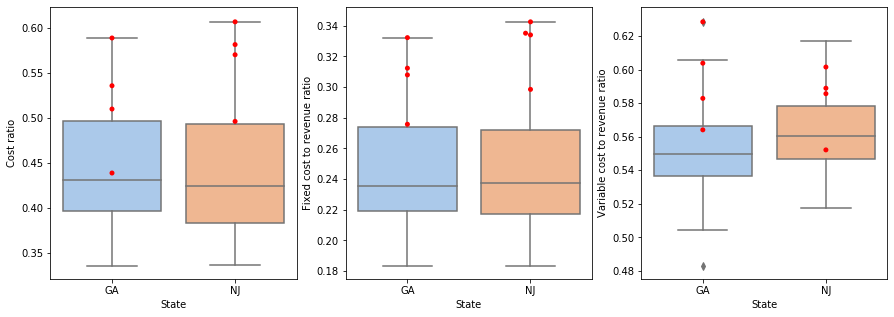

In [45]:
df_state = df_annual[(df_annual['State'] == 'NJ') | (df_annual['State'] == 'GA')]
df_state_under = df_state[df_state['Profit margin'] < pm_mean - 2*pm_std]
#df_NJ.set_index('Month',inplace=True)

fig, ax = plt.subplots(1,3,figsize=(15,5))
sns.boxplot(x='State', y='Cost ratio',
            data = df_state, ax=ax[0], palette='pastel')
sns.swarmplot(x='State', y='Cost ratio',
              data = df_state_under,color='r',ax=ax[0])
sns.boxplot(x='State',y='Fixed cost to revenue ratio',
            data = df_state, ax=ax[1], palette='pastel')
sns.swarmplot(x='State',y='Fixed cost to revenue ratio',
              data = df_state_under,color='r',ax=ax[1])
sns.boxplot(x='State',y='Variable cost to revenue ratio',
            data = df_state, ax=ax[2], palette='pastel')
sns.swarmplot(x='State',y='Variable cost to revenue ratio',
              data = df_state_under,color='r',ax=ax[2])
plt.show()

In comparison to other stores within the same state, underperforming stores are associated with higher fixed and variable costs. The fixed cost to revenue and variable cost to revenue ratios are particularly high for underperforming stores in Georgia, while the variable cost to revenue ratio has less impact on underperformance for one store in New Jersey.

The cost structure, measured as the ratio between fixed costs and variable costs is higher for underperforming stores in both states, suggesting that cost efficiency is a significant factor driving underperformance.